# Load and import data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gc
import matplotlib.pyplot as plt
from data_processing import *
x_train, x_test, y_train, y_test = get_training_and_test_data()

16318 samples with 2334 features.
video_id + label_id + label + 37 Frames * 21 Landmarks * 3 Dimensions -> 2334
The shape of the data is:       (16318, 37, 21, 3)
The percentage of 0 entries is: 76.397 %
The array has a size of:        145.1 MB.
x_train shape: (14687, 37, 21, 3)
x_test shape: (1631, 37, 21, 3)
y_train shape: (14687,)
y_test shape: (1631,)
Labels:  [ 5 10 11 12 13 19 20 24 26]


In [2]:
# Map labels
original_labels = np.array([5, 10, 11, 12, 13, 19, 20, 24, 26])
label_mapping = {original: new for new, original in enumerate(original_labels)}
def map_labels(labels, mapping):
    return np.array([mapping[label] for label in labels])
y_train = map_labels(y_train, label_mapping)
y_test = map_labels(y_test, label_mapping)

# Augment
x_train, y_train = augment_with_finger_length(x_train, y_train, 5, 30)

# To multiframe
n_frames = 16
x_train, y_train = return_multi_frame(x_train, y_train, n_frames, 0.5, flat=False)
gc.collect()
x_test, y_test = return_multi_frame(x_test, y_test, n_frames, 0.5, flat=False)
gc.collect()

# To (16, 64)
a = x_train.reshape(-1, 16, 63)
b = np.zeros_like(x_train).reshape(-1, 16, 63)[:,:,0,None]
x_train = np.concatenate([a, b], axis=2)
del a, b
gc.collect()
x_test  = np.concatenate([x_test.reshape(-1, 16, 63),  np.zeros_like(x_test).reshape(-1, 16, 63)[:,:,0,None]], axis=2)

# To tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
del x_train
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
del y_train
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
del x_test
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
del y_test
print(x_train_tensor.shape, ytrain.shape)

0.0 %
13.62 %
27.23 %
40.85 %
54.47 %
68.09 %
81.7 %
95.32 %
new_x:  (788814, 16, 21, 3)
new_y:  (788814,)
new_x:  (14352, 16, 21, 3)
new_y:  (14352,)


In [3]:
# Create DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([788814, 16, 64])
torch.Size([788814])
torch.Size([14352, 16, 64])
torch.Size([14352])


# Define model

In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.dropout(out[:, -1, :]))
        return out

In [5]:
def evaluate(model, test_loader, criterion, device, num_batches=None):
    model.eval()
    test_loss = 0
    correct = 0
    length = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if num_batches is not None and batch_idx >= num_batches:
                break

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            length += len(data)

    test_loss /= length
    accuracy = 100. * correct / length
    print(f'Average loss: {test_loss:.4f}, Accuracy: {correct}/{length} ({accuracy:.2f}%)')
    return accuracy

In [6]:
# Hyperparameters
input_size = 64
hidden_size = 256
num_layers = 2
num_classes = 9
num_epochs = 3
learning_rate = 0.001
dropout = 0.5  # Adjust this value as needed

# Initialize the model
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Adding L2 regularization

# Training loop with early stopping
patience = 5
best_loss = float('inf')
counter = 0

/home/flore/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # first execute throws error
model.to(device)
print(device)

cuda


In [9]:
# Training loop
train_acc, test_acc = [], []
def train(model, train_loader, test_loader, criterion, optimizer, device, patience):
    global best_loss, counter
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader): # 50486 batches
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % 500 == 0:  print(batch_idx)
            if batch_idx % 5000 == 0:
                train_acc.append(evaluate(model, train_loader, criterion, device,num_batches=1000))
                test_acc.append(evaluate(model, test_loader, criterion, device))
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
                model.train()

train(model, train_loader, test_loader, criterion, optimizer, device, patience)

0
Average loss: 0.0341, Accuracy: 11494/64000 (17.96%)
Average loss: 0.0343, Accuracy: 2372/14352 (16.53%)
Epoch 0, Batch 0, Loss: 2.2078
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
Average loss: 0.0036, Accuracy: 58730/64000 (91.77%)
Average loss: 0.0045, Accuracy: 12987/14352 (90.49%)
Epoch 0, Batch 5000, Loss: 0.2925
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
Average loss: 0.0028, Accuracy: 60075/64000 (93.87%)
Average loss: 0.0045, Accuracy: 13103/14352 (91.30%)
Epoch 0, Batch 10000, Loss: 0.1134
10500
11000
11500
12000
0
Average loss: 0.0023, Accuracy: 60515/64000 (94.55%)
Average loss: 0.0042, Accuracy: 13151/14352 (91.63%)
Epoch 1, Batch 0, Loss: 0.1583
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
Average loss: 0.0016, Accuracy: 61684/64000 (96.38%)
Average loss: 0.0038, Accuracy: 13289/14352 (92.59%)
Epoch 1, Batch 5000, Loss: 0.0566
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
Average loss: 0.0013, Accuracy: 62163/64000 (97.13%)
Average loss: 0.0040, Acc

In [ ]:
torch.save(model.state_dict(), 'final.pth')

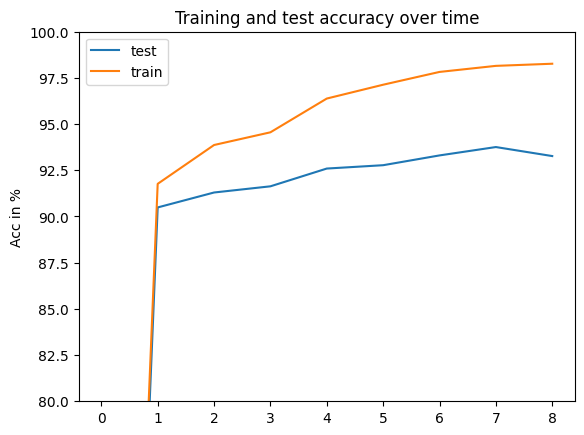

In [13]:
plt.plot(test_acc, label="test")
plt.plot(train_acc, label="train")
plt.legend()
plt.ylim(bottom=80, top=100)
plt.title("Training and test accuracy over time")
plt.ylabel("Acc in %")
plt.show()
# 3epoch_augment_fl_3_30

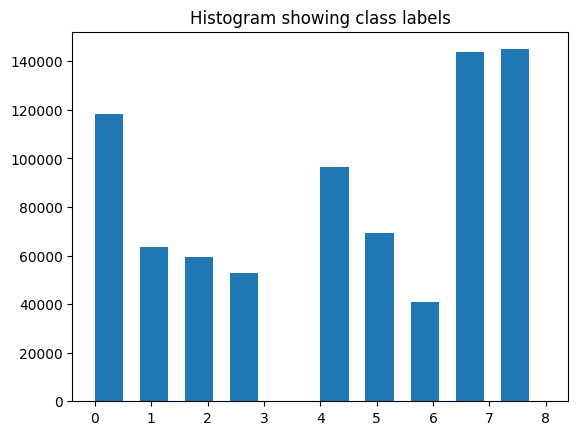

In [31]:
plt.hist(y_train_tensor, width=0.5)
plt.title("Histogram showing class labels")
plt.show()